In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [39]:
np.random.seed(42)

try:
    data = pd.read_csv('cleaned_data.csv')
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Check the file path or delimiter (e.g., sep=',' or sep='\t').")
    raise

print("Column names in dataset:", data.columns.tolist())


Column names in dataset: ['Price', 'Baths', 'Land size', 'Beds', 'House size', 'Seller_type', 'town', 'district']


In [40]:
data.columns = data.columns.str.strip()

#Feature engineering
data['is_colombo'] = (data['district'] == 'Colombo').astype(int)
data['Price_log'] = np.log(data['Price'])

numerical_features = ['Baths', 'Land size', 'Beds', 'House size', 'is_colombo']
categorical_features = ['town', 'district']
target = 'Price_log'

#Split data into training and testing sets
try:
    X = data[numerical_features + categorical_features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
except KeyError as e:
    print(f"Error: Column {e} not found. Verify column names in numerical_features, categorical_features, or target.")
    raise

In [41]:
#Preprocessing (done using AI)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=69, max_depth = 500))
])

In [43]:
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Random Forest:
RMSE: 0.38
R²: 0.77


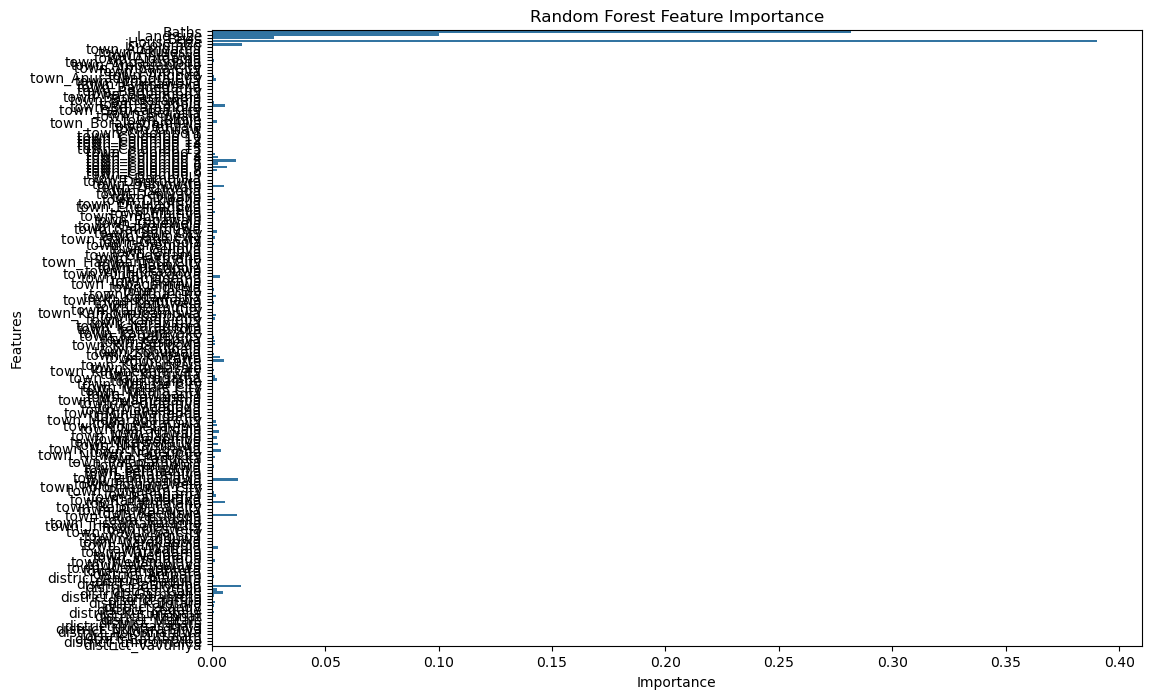

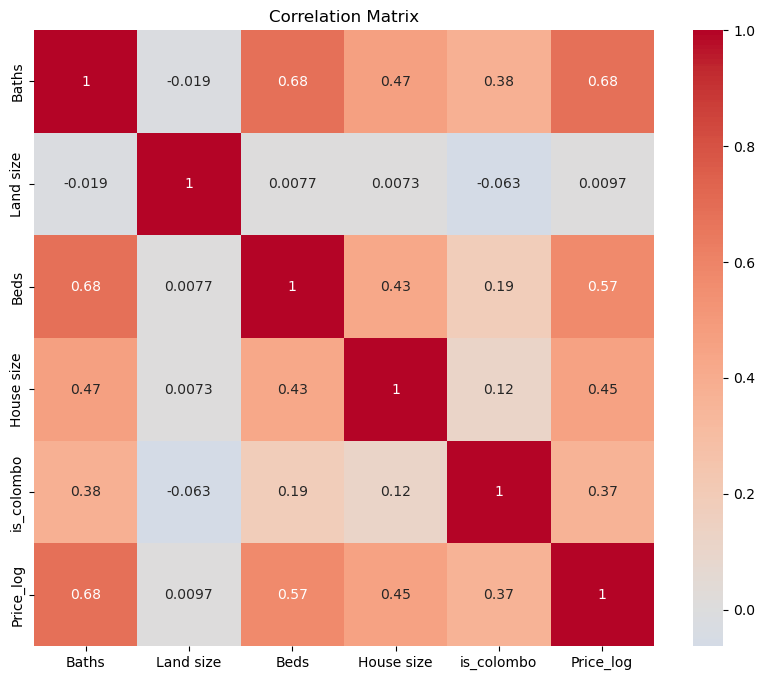

In [44]:
# Step 9: Feature importance for Random Forest
feature_importance = rf_pipeline.named_steps['model'].feature_importances_
ohe_feature_names = rf_pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png')
plt.show()

# Step 10: Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr_matrix = data[numerical_features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()